# fdsdf
https://www.youtube.com/watch?v=B08baRr2LlY - LSTM: Understanding the Number of Parameters

## Imports

In [73]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import uuid

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

# results path
RESULTS_PATH_HISTORY = os.path.abspath('task_two_results/histories/')
RESULTS_PATH_CONFIG_MATRICES = os.path.abspath('task_two_results/config_matrices/')

NUM_POINTS = 50
classes_arr = ['arrow', 'caret', 'check', 'circle', 'delete_mark', 'left_curly_brace', 'left_sq_bracket', 'pigtail', 'question_mark', \
               'rectangle', 'right_curly_brace', 'right_sq_bracket', 'star', 'triangle', 'v', 'x']

## Training Data (remaining data)

In [ ]:
data = []

for root, subdirs, files in os.walk('dataset'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

In [ ]:
print(data[0])

## validation data (10 gestures for each class)

In [21]:
validation_data = []

for class_label in classes_arr:
    counter = 0
    for i in range(len(data)):
        if counter < 10:
            if data[i][0] == class_label:
                validation_data.append(data[i])
                del data[i]
                counter += 1
        else:
            break

In [ ]:
print(validation_data[0])

## Prepare data and validation data

In [23]:
# Prepare the data
labels = [sample[0] for sample in data]
labels_val = [sample[0] for sample in validation_data]

print(set(labels))
print(set(labels_val))

encoder = LabelEncoder()
encoder_val = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_encoded_val = encoder_val.fit_transform(labels_val)

print(set(labels_encoded))
print(set(labels_encoded_val))

y = to_categorical(labels_encoded)
y_val = to_categorical(labels_encoded_val)

print(len(y[0]))
print(len(y_val[0]))

sequences = [sample[1] for sample in data]
sequences_val = [sample[1] for sample in validation_data]
X = np.array(sequences)
X_val = np.array(sequences_val)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train_val.shape, X_test_val.shape, y_train_val.shape, y_test_val.shape)

{'x', 'arrow', 'check', 'right_curly_brace', 'pigtail', 'triangle', 'circle', 'v', 'caret', 'question_mark', 'right_sq_bracket', 'rectangle', 'delete_mark', 'left_sq_bracket', 'star', 'left_curly_brace'}
{'x', 'arrow', 'check', 'right_curly_brace', 'pigtail', 'triangle', 'circle', 'v', 'caret', 'question_mark', 'right_sq_bracket', 'rectangle', 'delete_mark', 'left_sq_bracket', 'star', 'left_curly_brace'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
16
(4096, 50, 2) (1024, 50, 2) (4096, 16) (1024, 16)
(4096, 50, 2) (1024, 50, 2) (4096, 16) (1024, 16)


## train model method
parameter is a lsfm parameter count variant

In [24]:
def train_model(parameter_count):
    # Define the model
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(parameter_count, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early]
    )

    return model, history

## five different versions with systematically differtent LSTM’s parameter counts

In [25]:
# variant 1
model_16, history_16 = train_model(16)
# variant 2
model_32, history_32 = train_model(32)
# variant 3
model_64, history_64 = train_model(64)
# variant 4
model_128, history_128 = train_model(128)
# variant 5
model_256, history_256= train_model(256)

Epoch 1/20
128/128 [==============================] - 2s 8ms/step - loss: 2.2104 - accuracy: 0.3550 - val_loss: 1.5430 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 1.0887 - accuracy: 0.7102 - val_loss: 0.7455 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 5ms/step - loss: 0.5742 - accuracy: 0.8596 - val_loss: 0.4261 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 5ms/step - loss: 0.3559 - accuracy: 0.8955 - val_loss: 0.2883 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 6ms/step - loss: 0.2408 - accuracy: 0.9312 - val_loss: 0.1990 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 0.1584 - accuracy: 0.9622 - val_loss: 0.1153 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 5ms/step - lo

### model summaries

In [26]:
model_16.summary()
model_32.summary()
model_64.summary()
model_128.summary()
model_256.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1216      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 2,288
Trainable params: 2,288
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4480      
                                                                 
 dense_2 (Dense)             (No

### plot and save results
saved in 'task_two_results' folder

In [64]:
def plot_history(history, param_count_variant_str):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)
    plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

    plt.savefig(f"{RESULTS_PATH_HISTORY}\{param_count_variant_str}_results_{uuid.uuid4()}.png", format='png')

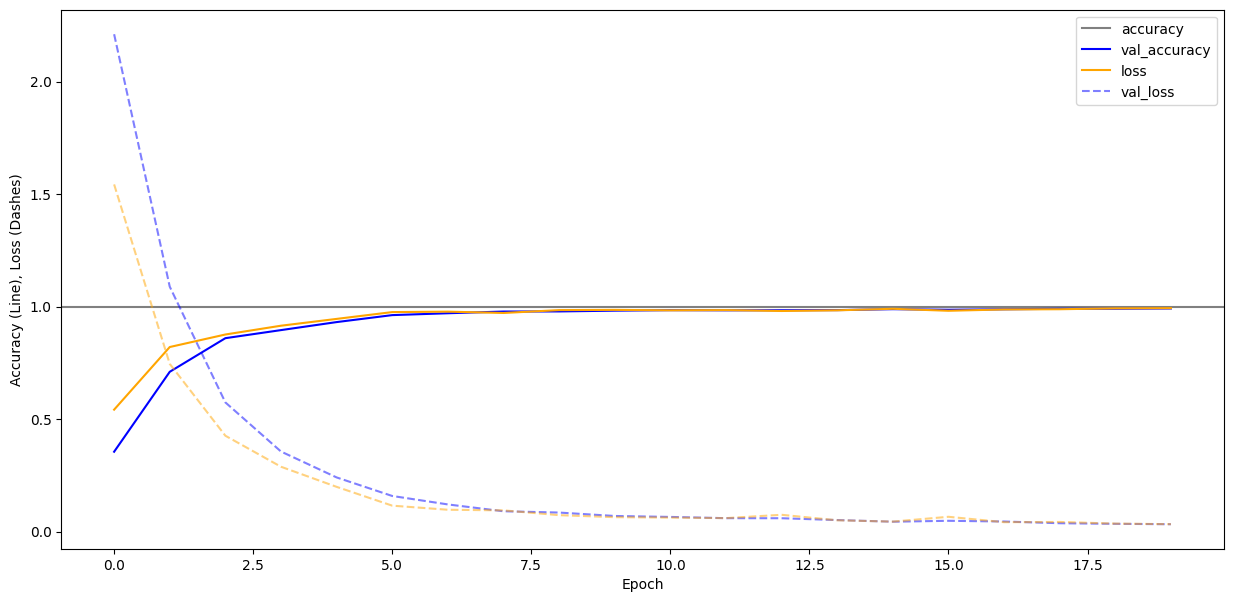

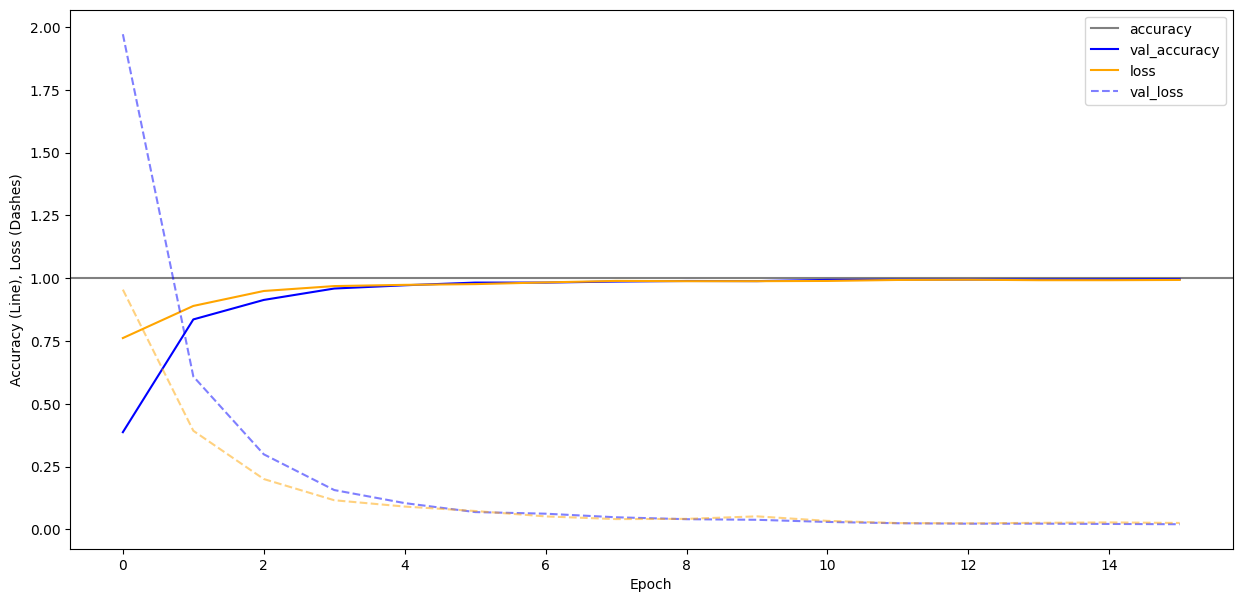

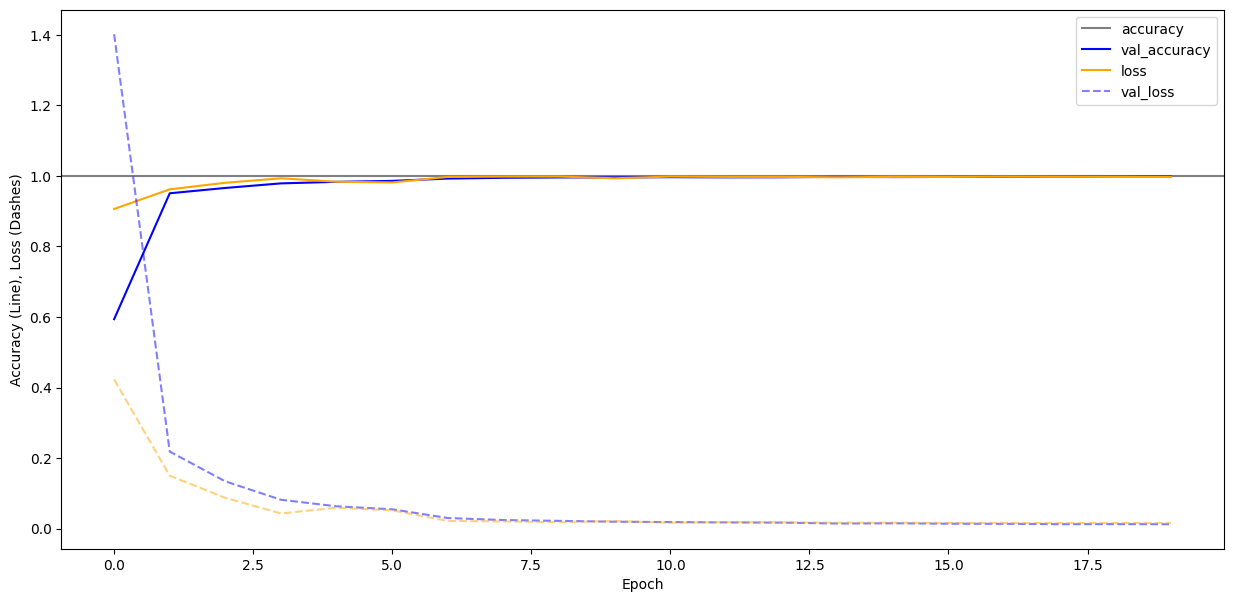

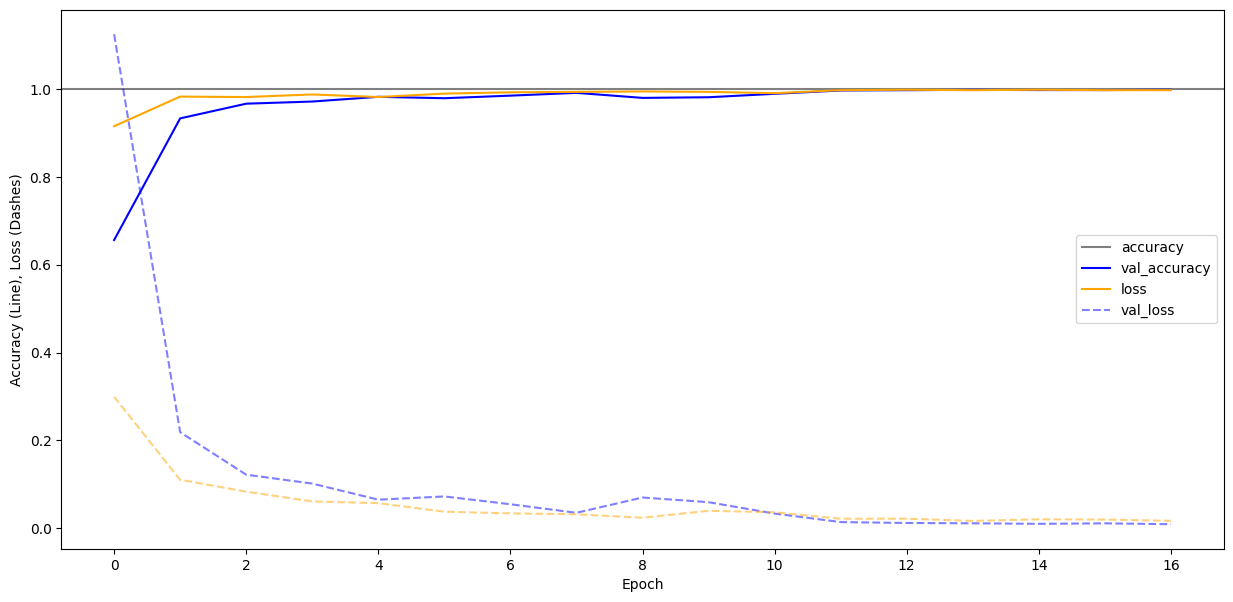

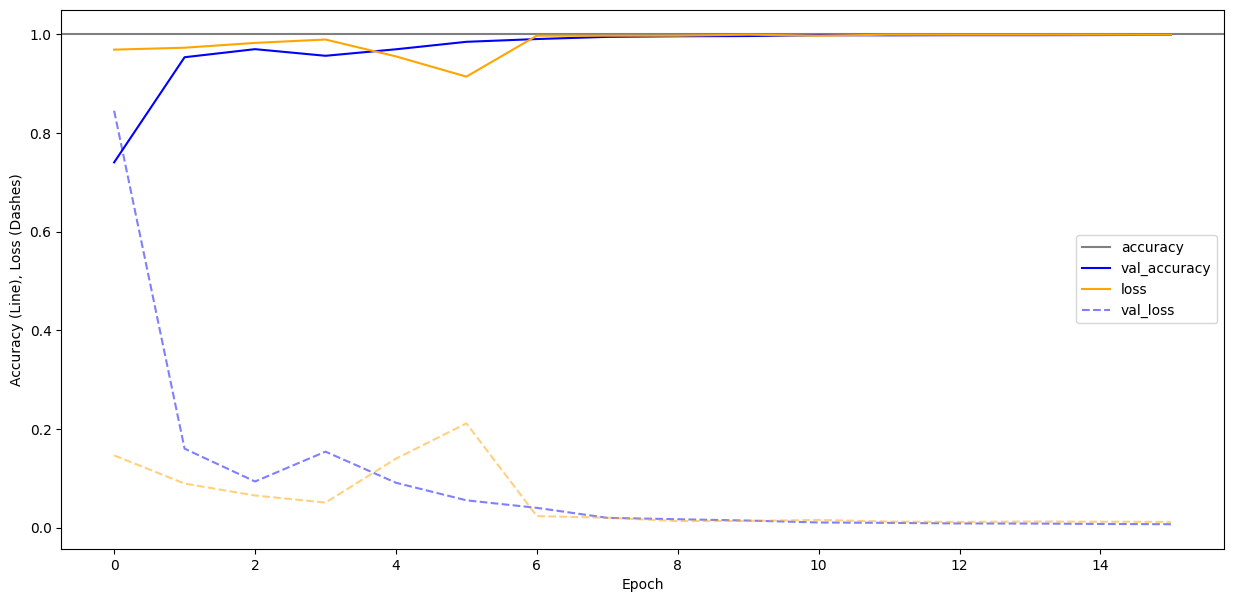

In [70]:
plot_history(history_16, 'param_count_16_history')
plot_history(history_32, 'param_count_32_history')
plot_history(history_64, 'param_count_64_history')
plot_history(history_128, 'param_count_128_history')
plot_history(history_256, 'param_count_256_history')

### prediction test for every model and save the config matrix
resulting configuration matrices are stored in the task_two_results folder

In [71]:
def predict(model, param_count_variant_str):
    # let the model make predictions for our training data
    y_predictions = model.predict(X_test)

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    plt.savefig(f"{RESULTS_PATH_CONFIG_MATRICES}\{param_count_variant_str}_config_matrix_{uuid.uuid4()}.png", format='png')
    pass


32/32 [==============================] - 0s 12ms/step


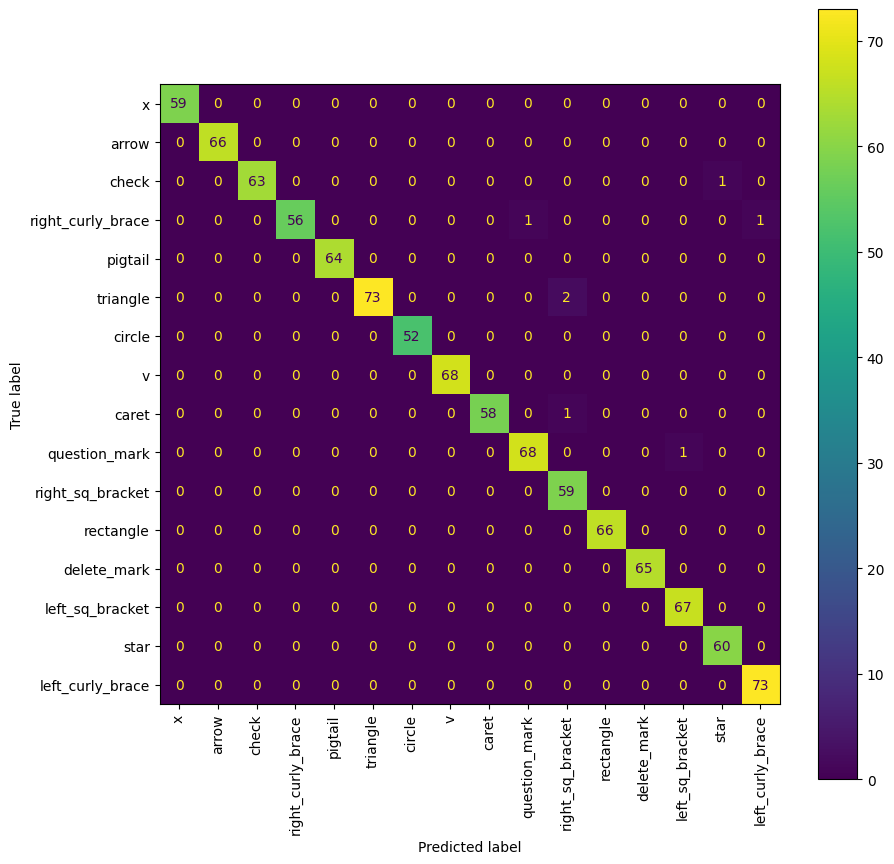

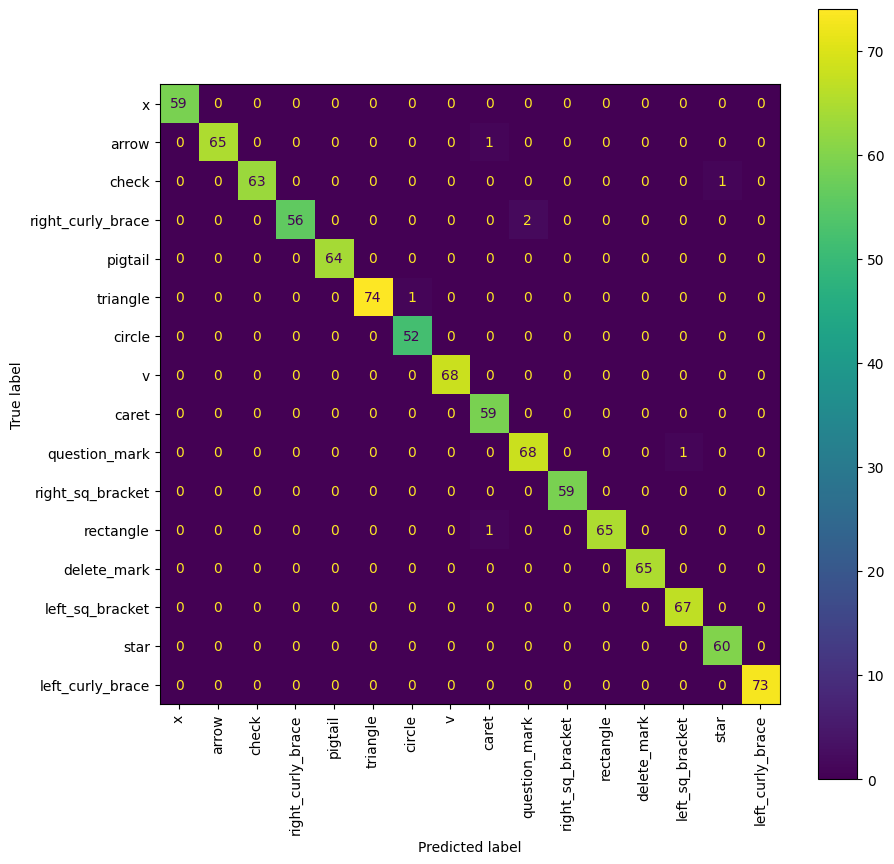

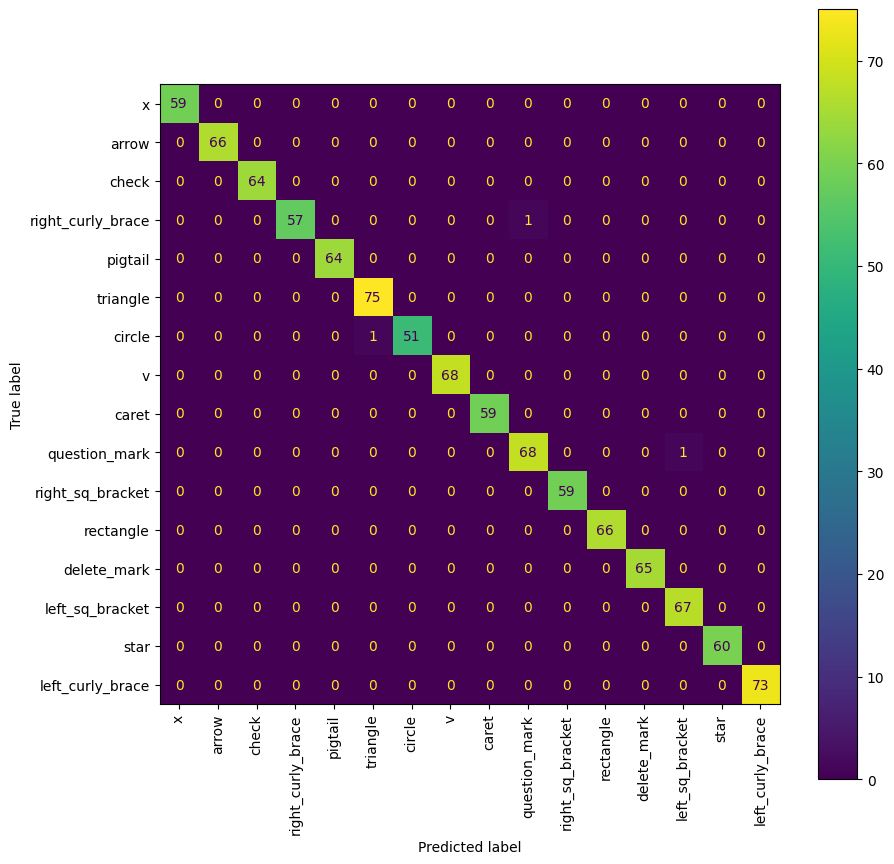

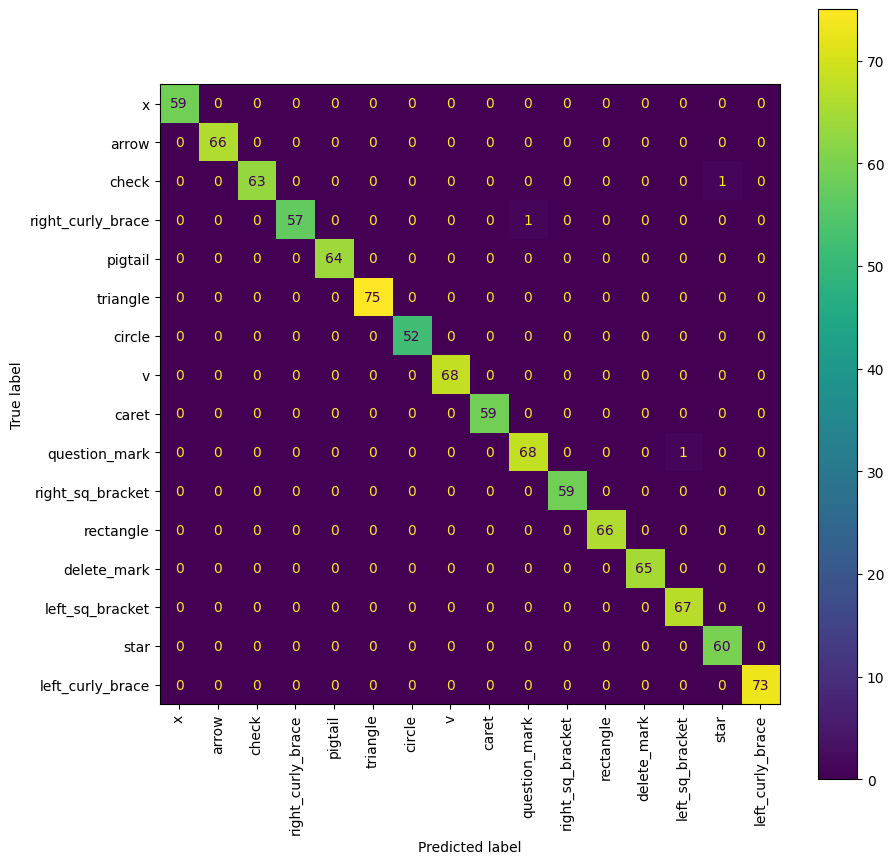

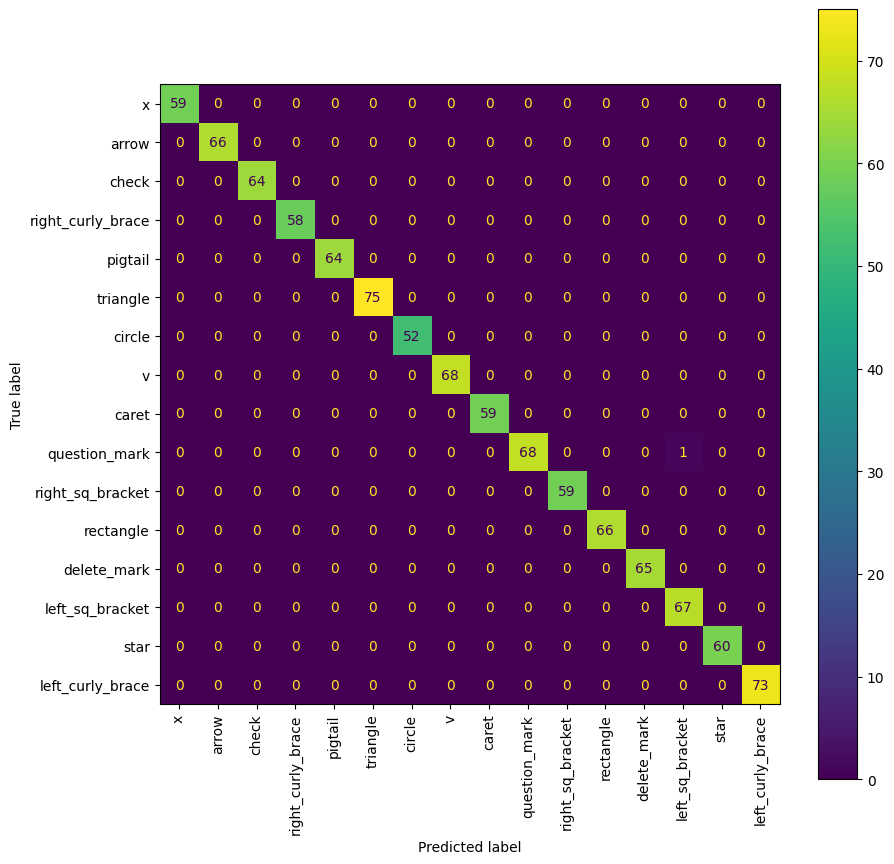

In [74]:
predict(model_16, 'param_count_16')
predict(model_32, 'param_count_32')
predict(model_64, 'param_count_64')
predict(model_128, 'param_count_128')
predict(model_256, 'param_count_256')

1/1 [==============================] - 0s 21ms/step
Label:      check
Prediction: check


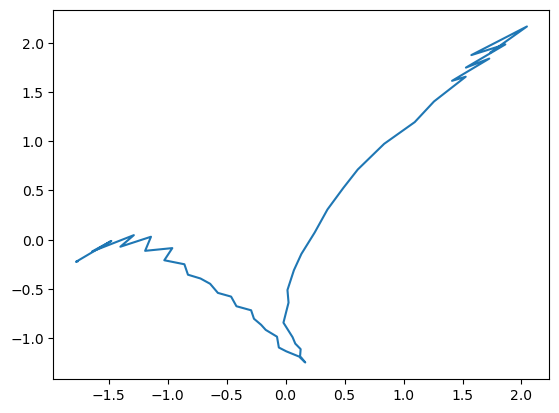

In [21]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)